#M3 Actividad
### Jesus Urquidez Calvo A00828368

Link de Collab: https://colab.research.google.com/drive/19sJ7zU3ErFyVfG4YgArFp4XshH-RA4lS?usp=sharing

##Descripcion de la Simulacion

Dentro de esta simulacion de trafico tenemos 4 agentes:

- **Celda**: Es un agente estatico que define segun sus parametros el camino a tomar.
- **Carro**: Es el agente principal de la simulacion, siempre esta en constante movimiento hasta que dentro de su rango tenga a un agente de tipo semaforo que le indique que se detenga
- **Semaforo**: Su funcion es estatica y permanecer dentro de cada interseccion sirviendo de mediador entre ambos cruces y definiendo que lado puede pasar por medio de su estado.
- **Luz**: Es un agente estatico que sirve de manera estetica para mostrar de manera mas visual el estado del semaforo dependiendo de la orientacion de la calle (horizontal o vertical)



In [1]:
!pip install mesa
from mesa import Agent, Model 

from mesa.space import MultiGrid

from mesa.time import SimultaneousActivation

from mesa.time import BaseScheduler


from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime
import random

     |████████████████████████████████| 668 kB 5.6 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 


In [2]:
def sum_tuple(x, y):
  return(x[0] + y[0], x[1] + y[1])

In [3]:
#Funcion auxiliar para la impresion
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for obj in cell_content:
          if isinstance(obj, Carro):
            grid[x][y] = 4
          elif isinstance(obj, Celda):
            grid[x][y] = obj.estado
          elif isinstance(obj, Luz):
            grid[x][y] = obj.estado

    return grid

In [4]:
class Carro(Agent):

  def __init__(self, unique_id, model, direction):
    super().__init__(unique_id, model)
    self.estilo = random.randint(0,3)
    self.direction = direction
    self.cont = 0

  def step(self):
    if(not self.pos == None):
      change = 1
      vecinos = self.model.grid.get_neighbors(
          self.pos, 
          moore = False,
          include_center = True)
      
      a = sum_tuple(self.pos, self.direction)

      for vecino in vecinos:
        if isinstance(vecino, Semaforo) and vecino.pos == a:
          if (not ((vecino.estado == 5 and self.direction == (1,0)) or (vecino.estado == 1 and self.direction == (0,1)))):
            change = 0
        if isinstance(vecino, Carro) and vecino.pos == a:
          change = 0

      if change:
        for vecino in vecinos:
          if isinstance(vecino, Celda) and vecino.pos == a:
            self.model.grid.move_agent(self, a)
            self.pos = a
            self.cont += 1

      if(self.cont == 8):
        self.model.grid.remove_agent(self)

class Celda(Agent):
  def __init__(self, unique_id, model, estado):
    super().__init__(unique_id, model)
    self.pos = unique_id
    self.estado = estado
    self.sig_estado = None

class Luz(Agent):

  def __init__(self, unique_id, model, orientacion):
    super().__init__(unique_id, model)
    self.pos = unique_id
    self.estado = 3
    self.orientacion = orientacion

  def step(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = True,
        include_center = False)
    for vecino in vecinos:
      if isinstance(vecino, Semaforo):
        if self.orientacion == 1:
          self.estado = vecino.estado
        else:
          self.estado = 6 - vecino.estado


class Semaforo(Agent):
  def __init__(self, unique_id, model, ticks):
    super().__init__(unique_id, model)
    self.ticks = ticks
    self.pos = unique_id
    self.estado = 3
    self.otro = 3
    self.tiempo = 0

  def step(self):
    up = sum_tuple(self.pos, (1,0))
    down = sum_tuple(self.pos, (-1,0))
    left = sum_tuple(self.pos, (0,-1))
    right = sum_tuple(self.pos, (0,1))

    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = False,
        include_center = False)
    
    change = 1

    if self.tiempo == 0:
      for vecino in vecinos:
        if isinstance(vecino, Carro) and (vecino.pos == up or vecino.pos == down):
          self.tiempo = self.ticks
          self.estado = 5
          break

      if self.tiempo == 0:
        for vecino in vecinos:
          if isinstance(vecino, Carro) and (vecino.pos == right or vecino.pos == left):
            self.tiempo = self.ticks
            self.estado = 1
            break
      
      if self.tiempo == 0:
        self.estado = 3

    elif self.tiempo > 0:
      self.tiempo -= 1



class Habitacion(Model):
  def __init__(self, ticks):
    self.grid = MultiGrid(9, 9, False)
    self.schedule = BaseScheduler(self)
    self.ticks = ticks
    self.cont = 0

    for(content, x, y) in self.grid.coord_iter():
      if x == 4 or y == 4:
        a = Celda((x,y), self, 2)
      else:
        a = Celda((x,y), self, 0)
      self.grid.place_agent(a,(x,y))
      self.schedule.add(a)

    #Agentes
    #Carro
    r = Carro(self.cont, self, (1,0))
    self.cont = self.cont + 1
    self.grid.place_agent(r, (0,4))
    self.schedule.add(r)

    #Semaforo
    r = Semaforo(self.cont, self, self.ticks)
    self.cont = self.cont + 1
    self.grid.place_agent(r, (4,4))
    self.schedule.add(r)

    #Luces
    r = Luz(self.cont, self, 1)
    self.cont = self.cont + 1
    self.grid.place_agent(r, (3,3))
    self.schedule.add(r)
    r = Luz(self.cont, self, 0)
    self.cont = self.cont + 1
    self.grid.place_agent(r, (5,5))
    self.schedule.add(r)
    
    self.datacollector = DataCollector(
        model_reporters = {"Grid":get_grid})
  
  def step(self):
    
    #Simulacion
    num = random.randint(0,5)
    if(num == 1):
      r = Carro(self.cont, self, (1,0))
      self.cont = self.cont + 1
      self.grid.place_agent(r, (0,4))
      self.schedule.add(r)

    num = random.randint(0,5)
    if(num == 1):
      r = Carro(self.cont, self, (0,1))
      self.cont = self.cont + 1
      self.grid.place_agent(r, (4,0))
      self.schedule.add(r)
      

    self.datacollector.collect(self)
    self.schedule.step()

In [5]:
tiempo_maximo = 0.05
ticks = 1

model = Habitacion(ticks)
start_time = time.time()

while((time.time() - start_time) < tiempo_maximo):
  model.step()

In [6]:
all_grid = model.datacollector.get_model_vars_dataframe()
#print(all_grid.to_string())

In [7]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.RdYlGn_r)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

In [8]:
anim

#Analisis de los Resultados


# Diagrama de maquina de estados


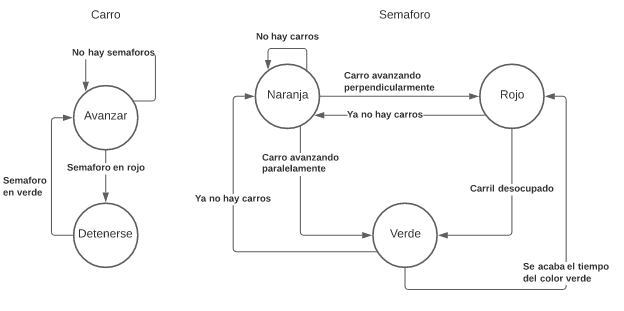